# Simulated Quantum Likelihood Estimation

Load libraries

In [1]:
%matplotlib inline

import os as os
import time as time
import qinfer as qi
import numpy as np
import importlib as importlib
import pickle as pkl
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from functools import partial
import importlib as imp
import future
import numpy as np
import scipy as sp
from scipy import linalg 
import time
import datetime
import sys, os
import time as time
import matplotlib.mlab as mlab
dire = os.getcwd()

In [2]:
imp.reload(qi)

<module 'qinfer' from '/home/brian/.local/lib/python3.5/site-packages/qinfer/__init__.py'>

In [3]:
sys.path.append(os.path.join("..", "..", "Libraries","QML_lib"))
import Evo as evo

## Set up list of probes

In [4]:
# initialise an array of random probe states
# TODO: generalise this to vectors of length 2^n... here n=1
global num_probes
global probes
global probe_counter
num_probes = 40
probes = np.empty([num_probes,2], dtype=complex)
probe_counter = 0

random_vectors = np.random.rand(num_probes,2)
imaginary = np.random.rand(num_probes,2)

# Want: alpha |0> + beta |1>, with alpha & beta complex. 
# Generate random alpha = alpha_real + j.alpha_imag
# normalise those 
# place in probes array

complex_vectors = np.empty([num_probes, 2])
complex_vectors = random_vectors +1.j*imaginary
alpha = complex_vectors[:,0]
beta = complex_vectors[:,1]
norm = np.empty([num_probes])
for l in range(0, num_probes):
    norm[l] = np.sqrt(np.abs(alpha[l])**2 + np.abs(beta[l])**2)
    normalised_alpha = alpha[l]/norm[l] 
    normalised_beta  = beta[l]/norm[l]
    probes[l,0] = normalised_alpha
    probes[l,1] = normalised_beta

In [5]:
def eval_loss(
        model, est_mean, true_mps=None,
        true_model=None, true_prior=None
    ):
    
    if true_model is None:
        true_model = model

    if true_mps is None:
        true_mps = true_model.update_timestep(
            promote_dims_left(true_mps, 2), expparams
        )[:, :, 0]

    if model.n_modelparams != true_model.n_modelparams:
        raise RuntimeError("The number of Parameters in True and Simulated model are different.")
                           
    n_pars = model.n_modelparams

    delta = np.subtract(*qi.perf_testing.shorten_right(est_mean, true_mps))
    loss = np.dot(delta**2, model.Q[-n_pars:])

    return loss


In [6]:
def get_prob(t, op_list, param_list):
    probe_preiodicity = 50
    num_terms = len(param_list)
    hamiltonian = 0
    for i in range(num_terms):
        hamiltonian += param_list[i]*op_list[i,:,:]
    unitary_param = (-1.j)*hamiltonian*t
    unitary_mtx = sp.linalg.expm(unitary_param)

    normalised_probe = np.array([probes[probe_counter%num_probes]])
    probe_bra = normalised_probe
    probe_ket = np.transpose(normalised_probe)
    u_probe = unitary_mtx @ probe_ket # perform unitary matrix of hamiltonian on ket form of probe state
    probe_u_probe = probe_bra @ u_probe # multiply be bra form of probe
    probability = abs(probe_u_probe)**2

    return float(probability)


In [7]:
class tHeurist(qi.Heuristic):
    
    def identity(arg): return arg
    
    def __init__(self, updater, t_field='ts',
                 t_func=identity,
                 maxiters=10
                 ):
        super(tHeurist, self).__init__(updater)
        self._t = t_field
        self._t_func = t_func
        self._maxiters = maxiters
        
    def __call__(self):
        idx_iter = 0
        while idx_iter < self._maxiters:
                
            x, xp = self._updater.sample(n=2)[:, np.newaxis, :] 
            if self._updater.model.distance(x, xp) > 0:
                break
            else:
                idx_iter += 1
                
        if self._updater.model.distance(x, xp) == 0:
            raise RuntimeError("PGH did not find distinct particles in {} iterations.".format(self._maxiters))
            
#        eps = np.empty((1,), dtype=self._updater.model.expparams_dtype)
        eps = np.zeros((1,), dtype=self._updater.model.expparams_dtype)
        eps[self._t]  = self._t_func(1 / self._updater.model.distance(x, xp))
        # this does not set non-time fields to anything in eps.... do we ever use those fields?
        return eps


In [8]:
class simulated_QLE(qi.FiniteOutcomeModel):
    
    def __init__(self, op_list, param_list): 
        self._param_list = param_list # Multiplicative parameters for operators
        self._op_list = op_list # Operators to form Hamiltonian 
        # Define Hamiltonian from operators and parameters list
        self._num_terms = len(self._param_list[0])
        super(simulated_QLE, self).__init__(self._op_list, self._param_list)
    
    ## Properties
    @property    
    def n_modelparams(self):
        return self._num_terms
    
    # Modelparams is the list of parameters in the System Hamiltonian - the ones we want to know
    # Possibly add a second axis to modelparams.    
    @property
    def modelparam_names(self):
        modnames = ['w0']
        for modpar in range(self.n_modelparams-1):
            modnames.append('w' + str(modpar+1))
        return modnames

    # expparams are the {t, w1, w2, ...} guessed parameters, i.e. each element 
    # is a particle with a specific sampled value of the corresponding parameter
  
    @property
    def expparams_dtype(self):
        expnames = [('ts', 'float')]
        for exppar in range(self.n_modelparams):
            expnames.append(('w' + str(exppar+1), 'float'))
        return expnames
    
    @property
    def is_n_outcomes_constant(self):
        """
        Returns ``True`` if and only if the number of outcomes for each
        experiment is independent of the experiment being performed.
        
        This property is assumed by inference engines to be constant for
        the lifetime of a Model instance.
        """
        return True

    ## Functions which are required to inherit from  FiniteOutcomeModel
    ## Currently filler to avoid errors. Will fill in as needed. 
    def are_models_valid(self, modelparams): 
        ## TODO: robust method here
#         w0, w1 = modelparams.T
#         this_thing= np.all(
#             [np.logical_and(w0 > 0, w0 <= 1),
#             np.logical_and(w1 >= -1, w1 <= 1)],
#             axis=0)
#         return this_thing
       
        return np.all(np.logical_and(modelparams > 0, modelparams <= 1), axis=1)        

    def n_outcomes(self, exp_params):
        return 2
        
    def likelihood(self, outcome, modelparams, expparams):
        if len(modelparams.shape) == 1:
            modelparams = modelparams[..., np.newaxis]
        
        t = expparams['ts']
        pr0 = np.zeros((modelparams.shape[0], expparams.shape[0])) 
        for idx_row in range(0, modelparams.shape[0]):
            for idx_col in range(0, expparams.shape[0]):
                pr0[idx_row, idx_col] = get_prob(t=t, op_list= self._op_list, param_list = modelparams[idx_row])
        likelihood = qi.FiniteOutcomeModel.pr0_to_likelihood_array(outcome, pr0)
        return likelihood    


In [9]:
def run_qle(param_list, op_list, n_particles, n_experiments, resample_thresh, resample_a): 
    # set mean and covariance based on true parameter list
    mean = np.zeros((len(param_list[0])))
    cov  = np.zeros((len(param_list[0]), len(param_list[0])))
    for a in range(len(param_list[0])):
        mean[a] = param_list[0,a] + 0.08
        cov[a,a] = 0.2
#         mean[a] = param_list[0,a] + 0.15
#         cov[a,a] = param_list[0,a] + 0.11
    prior = qi.MultivariateNormalDistribution(mean, cov)
    model = simulated_QLE(op_list=op_list, param_list=param_list)
    param_names = model.modelparam_names
    updater = qi.SMCUpdater(model, n_particles, prior, resample_thresh=resample_thresh, resample_a=resample_a)
    heuristic = tHeurist(updater, t_field='ts')
    track_parameters = np.zeros((len(param_list[0]), n_experiments))
    track_locations = np.zeros([n_particles, len(param_list[0]), n_experiments])
    track_weights = np.empty([n_particles, n_experiments])
    track_loss = np.empty(n_experiments)
    track_time = np.empty(n_experiments)
    resample_points=list()
    resample_points.append(0)
    
    probe_counter=0
    for idx in range(n_experiments):
        probe_counter+=1
        experiment=heuristic()
        datum = model.simulate_experiment(param_list, experiment)
        updater.update(datum, experiment)
        new_eval = updater.est_mean()
        for param in range(len(param_list[0])):
            track_parameters[param, idx] = new_eval[param]
        new_loss = eval_loss(model, new_eval, param_list)
        track_loss[idx] = new_loss[0]
        track_locations[:, :, idx] = updater.particle_locations
        track_weights[:, idx] = updater.particle_weights
        track_time[idx] = experiment[0][0] # time given by heuristic
        if updater.just_resampled is True:
            resample_points.append(idx)
    return track_parameters, track_loss, track_locations, track_weights, track_time, param_names, resample_points

## Run QLE 
Outputs of QLE: 
* Array qle_results with parameter values at each step
* loss array: quadratic loss at each experiment
* locations array: locations of particles at each experiment
* weights: weights at each experiment
* names: names of each parameter

In [10]:
# From loop over thresh = (0.5, 1.0); a=(0.70, 0.95), best found resampling threshold and a are as below.

min_thresh = 0.55
min_a = 0.7
n_particles=30
n_experiments=2
op_list=np.array([evo.sigmaz()])
param_list = np.array([[0.12]])
# op_list=np.array([evo.sigmax(), evo.sigmaz(), evo.sigmay()])
# param_list = np.array([[0.44, 0.12, 0.67]])
resample_thresh=min_thresh
resample_a=min_a
qle_results, loss, locations, weights, times, names, resample_points = \
    run_qle(param_list=param_list, op_list=op_list, n_particles=n_particles, \
            n_experiments=n_experiments, resample_thresh=resample_thresh, resample_a=resample_a)


In [66]:
n_particles=20
n_experiments=10
# op_list=np.array([evo.sigmax()])
# param_list = np.array([[0.44]])
op_list=np.array([evo.sigmax(), evo.sigmaz()])
param_list = np.array([[0.44, 0.12]])
resample_thresh=0.5
resample_a=0.95
qle_results, loss, locations, weights, times, names, resample_points = \
    run_qle(param_list=param_list, op_list=op_list, n_particles=n_particles, \
            n_experiments=n_experiments, resample_thresh=resample_thresh, resample_a=resample_a)


/home/brian/.local/lib/python3.5/site-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (9.521721554183458). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
/home/brian/.local/lib/python3.5/site-packages/qinfer/resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 4 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)


In [43]:
# to run QLE
# set n_particles, n_experiments, op_list, param_list
thresh_min=0.5
thresh_max=0.99
thresh_diff=0.05
resample_thresh_span = np.arange(thresh_min, thresh_max, thresh_diff)
num_thresh_vals = len(resample_thresh_span)

a_min=0.7
a_max=0.95
a_diff=0.01
resample_a_span=np.arange(a_min, a_max, a_diff)
num_a_vals=len(resample_a_span)
final_losses = np.zeros((num_thresh_vals*num_a_vals,3))
#resample_thresh=0.5
#resample_a=0.9

n_particles=300
n_experiments=250
op_list=np.array([evo.sigmax()])
param_list = np.array([[0.44]])
#op_list=np.array([evo.sigmax(), evo.sigmaz(), evo.sigmay()])
#param_list = np.array([[0.44, 0.86, 0.5]])

# For loop to calculate quadratic loss for ranges of resampling threshold & a. 
k=0
for i in range(num_thresh_vals):
    resample_thresh = resample_thresh=resample_thresh_span[i]
    for j in range(num_a_vals):
        resample_a = resample_a_span[j]
        qle_results, loss, locations, weights, times, names, resample_points = \
            run_qle(param_list=param_list, op_list=op_list, n_particles=n_particles, \
                    n_experiments=n_experiments, resample_thresh=resample_thresh, resample_a=resample_a)
        final_losses[k][0]=resample_thresh
        final_losses[k][1]=resample_a
        final_losses[k][2]=loss[n_experiments-1]
        k+=1

/home/brian/.local/lib/python3.5/site-packages/qinfer/utils.py:268: ApproximationWarning: Numerical error in covariance estimation causing positive semidefinite violation.
  warnings.warn('Numerical error in covariance estimation causing positive semidefinite violation.', ApproximationWarning)
/home/brian/.local/lib/python3.5/site-packages/qinfer/resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 1 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)
/home/brian/.local/lib/python3.5/site-packages/qinfer/resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 2 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)
/home/brian/.local/lib/python3.5/site-packages/qinfer/resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 4 particles within 1000 iterations.
  ).format(idxs_to_resample.size

In [81]:
store_losses_array = final_losses
min_loss=1
min_loc=0
for i in range(len(store_losses_array)):
    if(store_losses_array[i,2]) < min_loss:
        min_loss = store_losses_array[i,2]
        min_loc = i
        
min_thresh = store_losses_array[min_loc,0]
min_a = store_losses_array[min_loc,1]
n_particles=300
n_experiments=200
op_list=np.array([evo.sigmaz()])
param_list = np.array([[0.12]])
# op_list=np.array([evo.sigmax(), evo.sigmaz(), evo.sigmay()])
# param_list = np.array([[0.44, 0.12, 0.67]])
resample_thresh=min_thresh
resample_a=min_a
qle_results, loss, locations, weights, times, names, resample_points = \
    run_qle(param_list=param_list, op_list=op_list, n_particles=n_particles, \
            n_experiments=n_experiments, resample_thresh=resample_thresh, resample_a=resample_a)


## Plots
* Plot parameter values Vs experiment number

i= 0
True value for  w0  =  0.12
Estimated value for  w0  =  -0.001097182534 



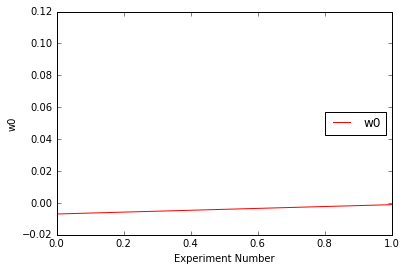

In [11]:
num_params = np.shape(qle_results)[0]
num_exps = np.shape(qle_results)[1]
colours = np.array(['r','g','b','k','y'])

for i in range(num_params):
    print('i=', i)
    print('True value for ', names[i], ' = ', param_list[0,i])
    print('Estimated value for ', names[i], ' = ', qle_results[i, num_exps -1], '\n')    
    plt.axhline(y=param_list[0,i], xmin=0, xmax=n_experiments, hold=None, color=colours[i%len(colours)])
    plt.plot(qle_results[i], label=names[i],color=colours[i])
    plt.legend(loc='center right')
    plt.xlabel('Experiment Number')
    plt.ylabel(names[i])

* Time chosen by heuristic Vs exeriment number

## Plot prior distributions
In particular, check distribution before and after resampling (in resample_points). 

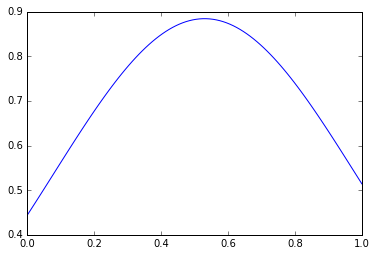

In [77]:
timestep=resample_points[len(resample_points)-1]
timestep = resample_points[0]
mean = np.mean(locations[:,0,timestep])
cov = np.std(locations[:,0,timestep])
omegaslist = np.linspace(0, 1, 100)
plt.plot(omegaslist,mlab.normpdf(omegaslist, mean, cov))
plt.show()

## Plot log of times Vs epoch

plt.semilogy(times)
plt.xlabel('# of Measurements')
plt.ylabel('t from PGH')

plt.show()

## Plot log of quadratic loss Vs epoch

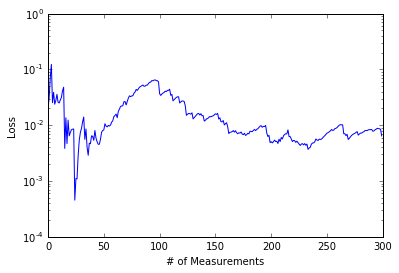

In [78]:
plt.semilogy(loss)
plt.xlabel('# of Measurements')
plt.ylabel('Loss')

plt.show()

* Particle locations at each experiment. 

Timestep = experiment number. Change this to observe how particles (should) converge over experiments

ValueError: x and y must be the same size

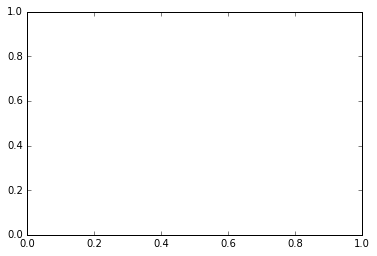

In [148]:
timestep=2
#timestep = n_experiments-1
# this is for 2 parameters
plt.scatter(locations[:,0,timestep], locations[:,1,timestep], c=weights[:,timestep], cmap=plt.cm.RdYlGn)
plt.show()

## Plot weights of each particle at a given timestep

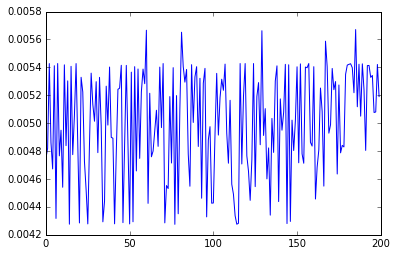

In [227]:
timestep=42
#timestep = n_experiments-1
plt.plot(weights[:,timestep])
plt.show()